# Plot ARI timeseries

In [ ]:
import pandas as pd
from src.realtime_utils import load_realtime_training_data
from plotnine import (
    ggplot,
    geom_rect,
    geom_vline,
    annotate,
    geom_line,
    scale_x_date,
    element_blank,
    element_line,
    coord_cartesian,
    aes,
    facet_wrap,
    theme,
    theme_bw,
    labs,
    element_text,
    scale_fill_manual,
    scale_y_continuous,
)

# Load data

In [3]:
targets, covariates = load_realtime_training_data()

In [ ]:
train_end = pd.Timestamp("2022-10-02")
validation_end = pd.Timestamp("2023-11-16")
test_end = pd.Timestamp("2024-10-06")

In [ ]:
highlight_areas = pd.DataFrame(
    {
        "xmin": [targets.start_time(), train_end, validation_end],
        "xmax": [train_end, validation_end, test_end],
        "period": ["Train", "Validation", "Test"],
    }
)

In [ ]:
covariates = covariates[targets.start_time() : test_end]
df = covariates.to_dataframe().reset_index()

In [ ]:
covid_start = pd.Timestamp("2019-06-30")
covid_end = pd.Timestamp("2023-07-03")

In [ ]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha="center", ma="right"),
        axis_text_y=element_text(size=8),
    )

In [ ]:
target_col = "agi-are-DE"

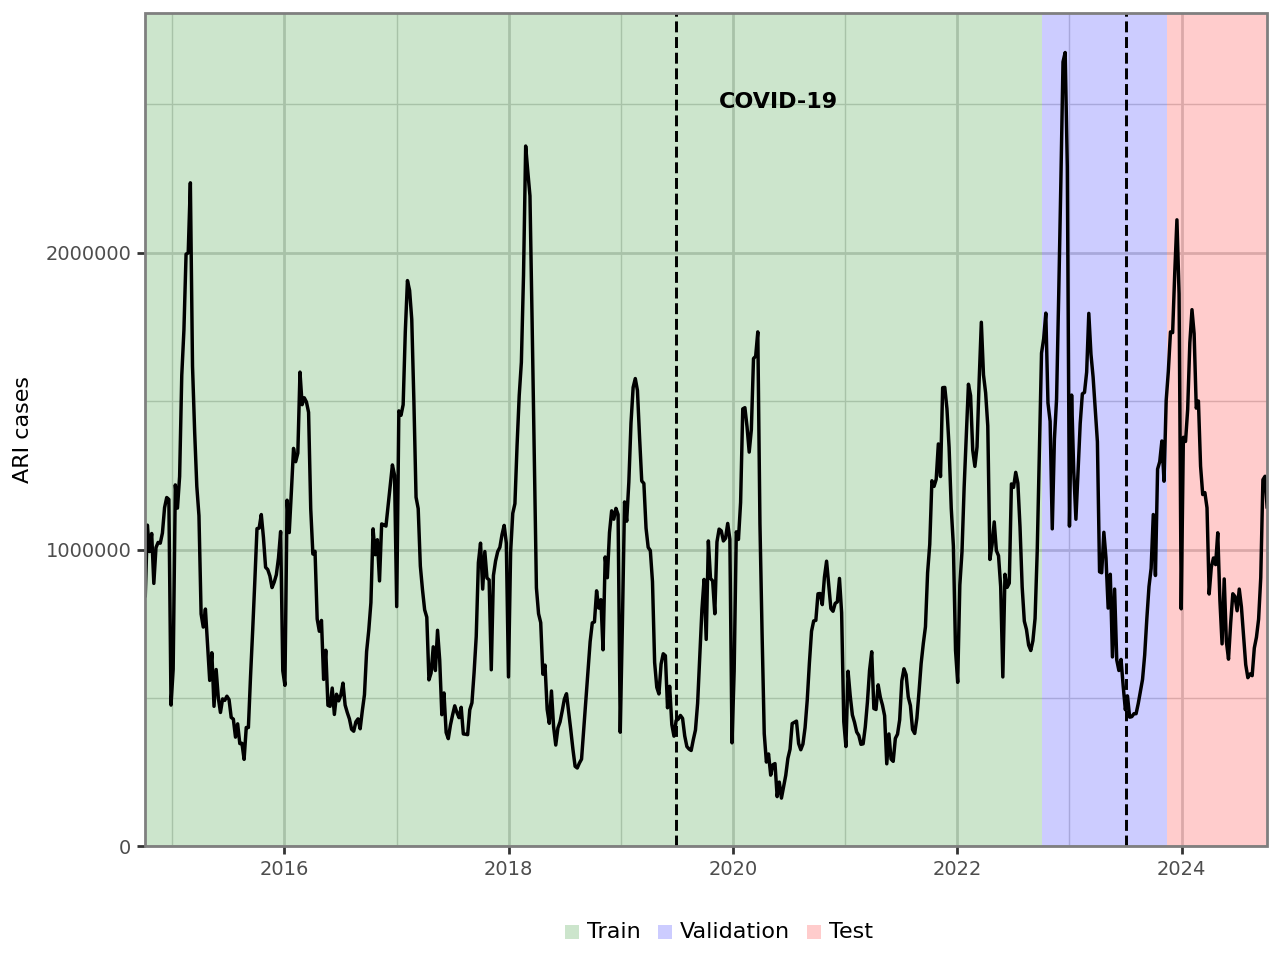

In [ ]:
plot = (
    ggplot()
    + geom_rect(
        data=highlight_areas,
        mapping=aes(
            xmin="xmin",
            xmax="xmax",
            ymin=-float("inf"),
            ymax=float("inf"),
            fill="period",
        ),
        alpha=0.2,
    )
    + geom_vline(xintercept=covid_start, linetype="dashed", color="black", size=0.6)
    + geom_vline(xintercept=covid_end, linetype="dashed", color="black", size=0.6)
    +
    # Label for COVID-19 start
    annotate(
        "text",
        x=covid_start + pd.Timedelta(weeks=20),
        y=df[target_col].max()
        * 0.925,  # Slightly below the max y value for positioning
        label="COVID-19",
        ha="left",  # Align text to the left of the line
        va="bottom",  # Position text just above the line
        size=8,
        color="black",
        fontweight="bold",
    )
    + geom_line(df, aes(x="date", y=target_col), size=0.7)
    + labs(x="", y="ARI cases", fill="")
    + scale_x_date(
        breaks=[
            pd.Timestamp("2016-01-01"),
            pd.Timestamp("2018-01-01"),
            pd.Timestamp("2020-01-01"),
            pd.Timestamp("2022-01-01"),
            pd.Timestamp("2024-01-01"),
        ],
        labels=["2016", "2018", "2020", "2022", "2024"],
        minor_breaks=pd.date_range(start="2015-01-01", end="2024-01-01", freq="YS"),
    )
    + scale_y_continuous(limits=(0, df[target_col].max() * 1.05))
    + scale_fill_manual(
        values={"Train": "green", "Validation": "blue", "Test": "red"},
        limits=["Train", "Validation", "Test"],
    )  # To order the legend
    + theme_bw()
    + custom_theme()
    + theme(
        legend_position="bottom",
        axis_text_x=element_text(size=7, rotation=0),
        axis_text_y=element_text(size=7),
        legend_text=element_text(size=8),
        axis_title=element_text(size=8),
        legend_key=element_blank(),
        legend_key_size=5,
        panel_grid_minor_x=element_line(size=0.5, color="lightgrey"),
        panel_grid_major_x=element_line(size=1, color="lightgrey"),
        panel_grid_minor_y=element_line(size=0.5, color="lightgrey"),
        panel_grid_major_y=element_line(size=1, color="lightgrey"),
    )
    + coord_cartesian(expand=False)
)

plot

In [ ]:
plot.save(
    "../figures/ari_periods.pdf",
    width=80,
    height=45,
    units="mm",
    dpi=600,
    verbose=False,
)

# Plot age groups

In [ ]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8),
        axis_text_y=element_text(size=8),
    )

In [ ]:
df_long = pd.melt(df, id_vars=["date"], var_name="age_group", value_name="value")
df_long["age_group"] = df_long["age_group"].str.split("-", n=2).str[2]
df_long.age_group = df_long.age_group.replace({"DE": "00+"})
df_long["age_group"] = pd.Categorical(
    df_long["age_group"],
    categories=["00-04", "05-14", "15-34", "35-59", "60+", "00+"],
    ordered=True,
)
df_long = df_long[df_long.age_group != "00+"]

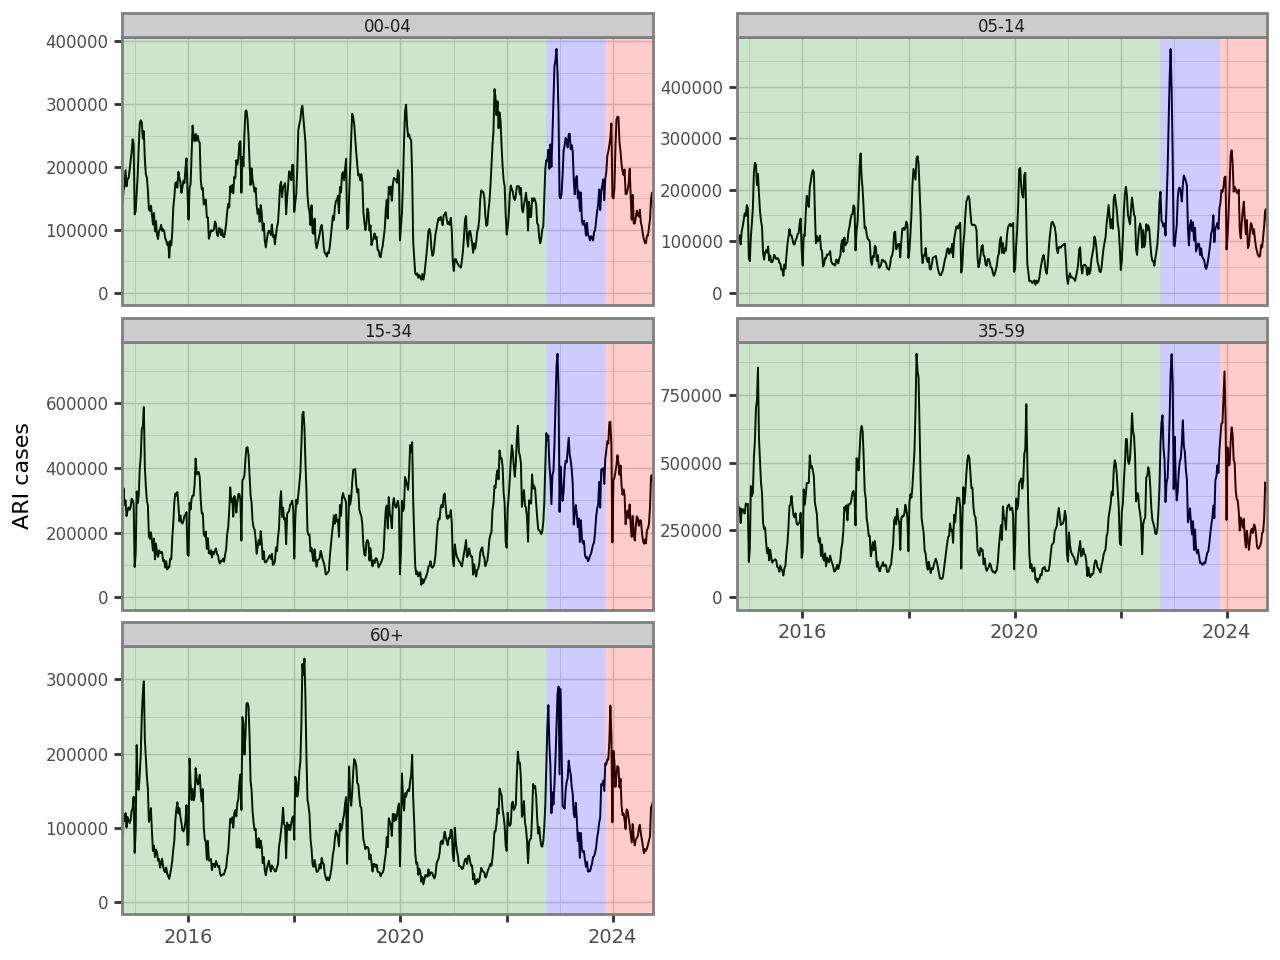

In [ ]:
plot = (
    ggplot()
    + geom_line(df_long, aes(x="date", y="value"), size=0.4)
    + geom_rect(
        data=highlight_areas,
        mapping=aes(
            xmin="xmin",
            xmax="xmax",
            ymin=-float("inf"),
            ymax=float("inf"),
            fill="period",
        ),
        alpha=0.2,
    )
    + facet_wrap("age_group", scales="free_y", ncol=2)
    + labs(x="", y="ARI cases", fill="")
    + scale_x_date(
        breaks=[
            pd.Timestamp("2016-01-01"),
            pd.Timestamp("2018-01-01"),
            pd.Timestamp("2020-01-01"),
            pd.Timestamp("2022-01-01"),
            pd.Timestamp("2024-01-01"),
        ],
        labels=["2016", "", "2020", "", "2024"],
        minor_breaks=pd.date_range(start="2015-01-01", end="2024-01-01", freq="YS"),
        expand=(0, 0, 0, 0),
    )
    + scale_y_continuous(limits=(0, None))
    + scale_fill_manual(
        values={"Train": "green", "Validation": "blue", "Test": "red"},
        limits=["Train", "Validation", "Test"],
    )
    + theme_bw()
    + custom_theme()
    + theme(
        legend_position="none",
        strip_text=element_text(size=6, margin={"t": 1, "b": 1}),
        axis_text_x=element_text(size=7, rotation=0),
        axis_text_y=element_text(size=6),
        legend_text=element_text(size=8),
        axis_title=element_text(size=8),
        legend_key=element_blank(),
        legend_key_size=5,
        panel_grid_minor_x=element_line(size=0.25, color="lightgrey"),
        panel_grid_major_x=element_line(size=0.5, color="lightgrey"),
        panel_grid_minor_y=element_line(size=0.25, color="lightgrey"),
        panel_grid_major_y=element_line(size=0.5, color="lightgrey"),
    )
)

plot

In [ ]:
plot.save(
    "../figures/ari_age.pdf", width=80, height=45, units="mm", dpi=600, verbose=False
)